In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
acquisition_fm6_path = {
    "pre-vib": "data/previb/20241126_1657_hermes_h6_176Lu_67465EDA_900s_LV0d5.fits",
    "post-tvac": "data/posttvac/merged_20241218_hermes_h6_176Lu_900s_LV0d5.fits",
}

lu176_201 = 201.83
lu176_306 = 306.78
sources = [lu176_201, lu176_306]

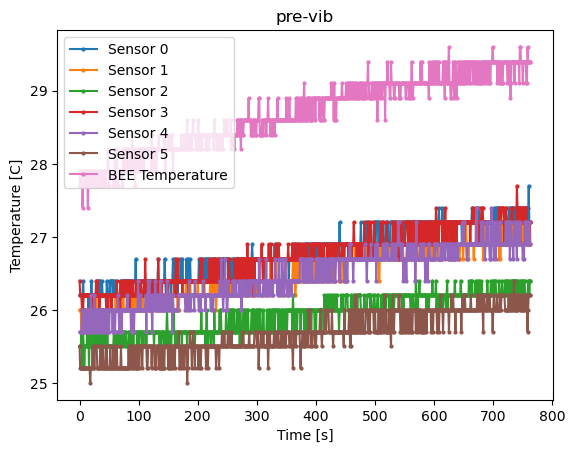

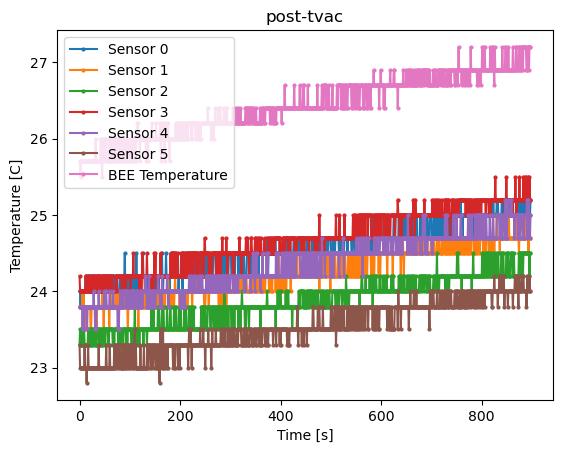

In [3]:
from astropy.io import fits

for label, filepath in acquisition_fm6_path.items():
    with fits.open(filepath) as f:
        hk_data = f[1].data

    temp_array = np.hstack((hk_data["FEETEMPP"], np.expand_dims(hk_data["BEETEMPP"], axis=1)))
    temp_df = pd.DataFrame(temp_array, columns=[f"Sensor {i}" for i in range(6)] + ["BEE Temperature"])
    temp_df.plot(ylabel="Temperature [C]", xlabel="Time [s]", marker="o", title=f"{label}", kind="line", ms=2)
    plt.show()

In [6]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_lv0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return

    def log(self, msg):
        pass

configuration = {"xbinning": 10, "sbinning": 20}
model="fm6"

sdd_calibration = read_sdd_calibration_report(Path("calibs/standard/sdds.xlsx"))
slo_calibration = read_lightout_report(Path("calibs/standard/lightoutput.xlsx"))

sdd_previb_calib = read_sdd_calibration_report(Path("calibs/previb/sdds.xlsx"))
slo_previb_calib = read_lightout_report(Path("calibs/previb/lightoutput.xlsx"))

sdd_posttvac_calib = read_sdd_calibration_report(Path("calibs/posttvac/sdds.xlsx"))
slo_posttvac_calib = read_lightout_report(Path("calibs/posttvac/lightoutput.xlsx"))


def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_lv0d5(datafile)
    print(f"onto {datafile}..")
    data, waste = preprocess(
        data,
        model=model,
        filter_spurious=True,
        filter_retrigger=20*10**-6,
    )
    calibration = ImportedCalibration(
        model=model,
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )
    return calibration(data), calibration


calibrate_standard = partial(_calibrate_data, model=model, sdd_calibration=sdd_calibration, slo_calibration=slo_calibration, configuration=configuration)

calibrate_previb = partial(_calibrate_data, model=model, sdd_calibration=sdd_previb_calib, slo_calibration=slo_previb_calib, configuration=configuration)

calibrate_posttvac = partial(_calibrate_data, model=model, sdd_calibration=sdd_posttvac_calib, slo_calibration=slo_posttvac_calib, configuration=configuration)

In [5]:
dfs_previb = {label: calibrate_previb(datafile) for label, datafile in acquisition_fm6_path.items()}

onto data/previb/20241126_1657_hermes_h6_176Lu_67465EDA_900s_LV0d5.fits..


onto data/posttvac/merged_20241218_hermes_h6_176Lu_900s_LV0d5.fits..


In [6]:
dfs_posttvac = {label: calibrate_posttvac(datafile) for label, datafile in acquisition_fm6_path.items()}

onto data/previb/20241126_1657_hermes_h6_176Lu_67465EDA_900s_LV0d5.fits..


onto data/posttvac/merged_20241218_hermes_h6_176Lu_900s_LV0d5.fits..


# Counts

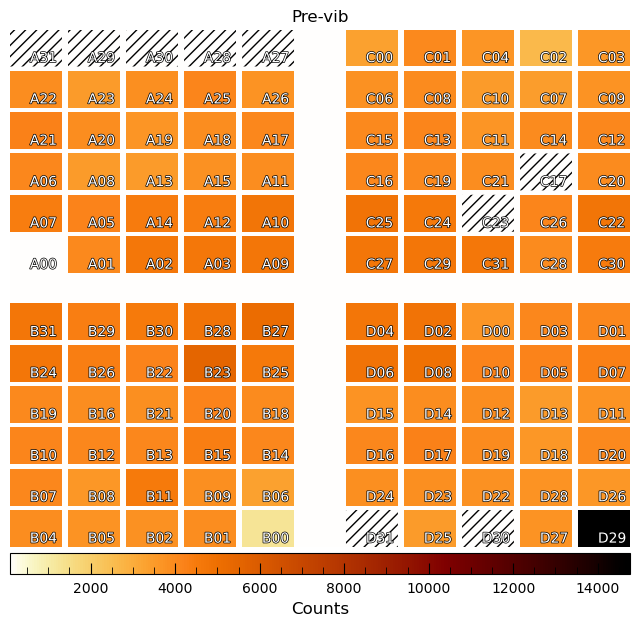

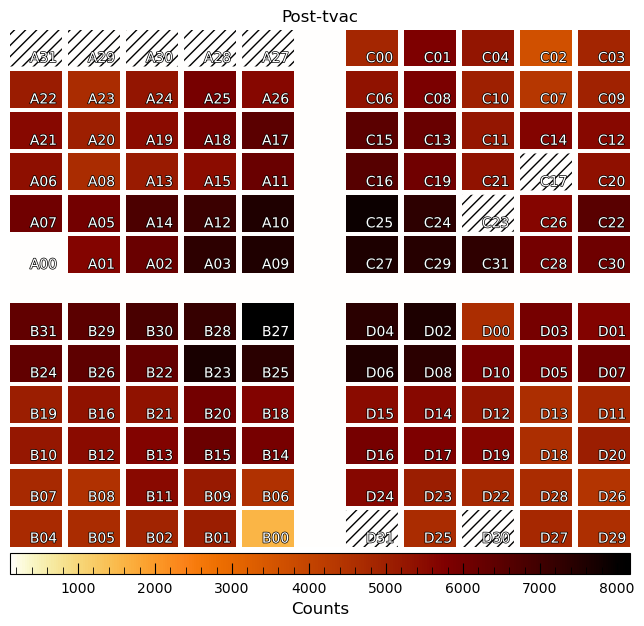

In [7]:
from source.io import pandas_from_lv0d5
from source.plot import mapcounts
from source.calibrate import perchannel_counts
from source.detectors import Detector

dmap = Detector("fm6").map

df = pandas_from_lv0d5(acquisition_fm6_path["pre-vib"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Pre-vib")


df = pandas_from_lv0d5(acquisition_fm6_path["post-tvac"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Post-tvac")

# Spectra

In [8]:
def histogram(data):
    bins = np.arange(50, 1500, .5)
    midpoints = (bins[:-1] + bins[1:]) / 2
    return np.histogram(data["ENERGY"], bins=bins)[0], midpoints

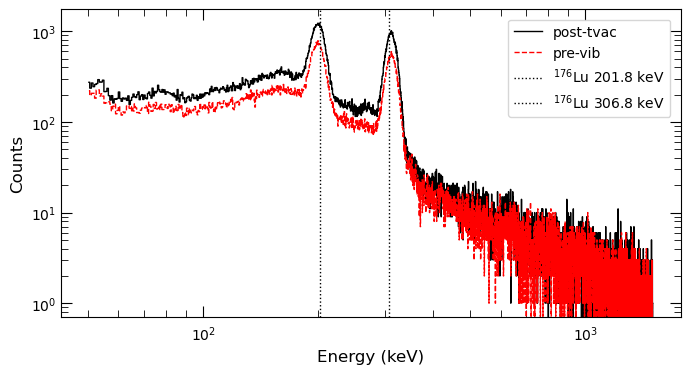

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

label = "post-tvac"
data, calibration = dfs_posttvac[label]
counts, midpoints = histogram(data)
ax.step(midpoints, counts, where="mid", label=label)

label = "pre-vib"
data, calibration = dfs_previb[label]
counts, midpoints = histogram(data)
ax.step(midpoints, counts, where="mid", label=label)

for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.show()

# Light output changes

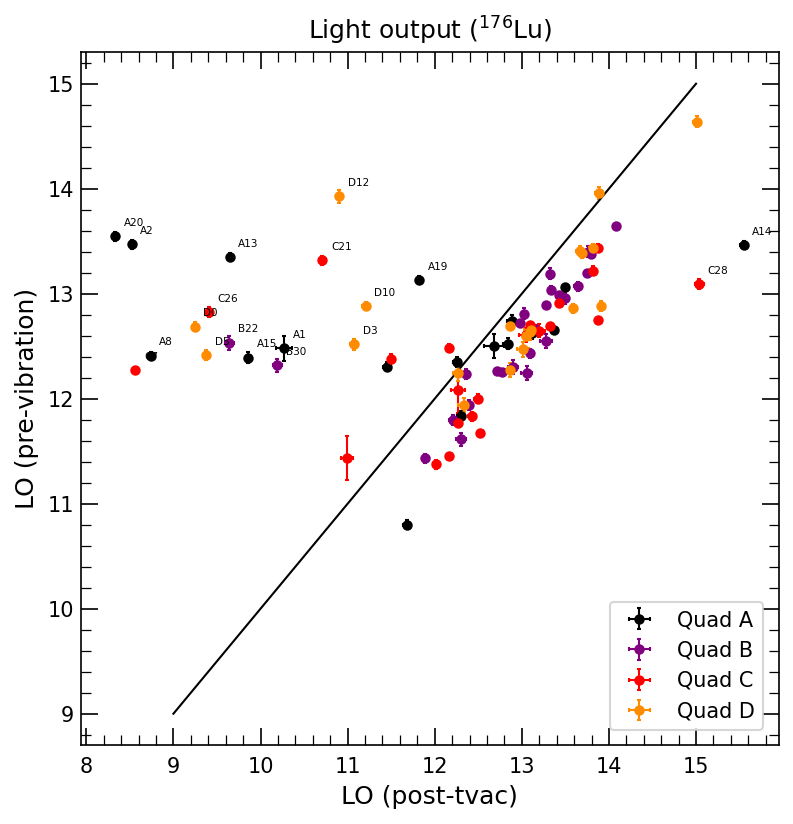

In [19]:
plt.subplots(1, 1, figsize=(6,6), dpi=150)
for quad, color in zip("ABCD",["black", "purple", "red", "darkorange"]):
    indeces = slo_previb_calib[quad]["light_out"].index.intersection(slo_posttvac_calib[quad]["light_out"].index)
    plt.errorbar(
        slo_posttvac_calib[quad]["light_out"][indeces],
        slo_previb_calib[quad]["light_out"][indeces],
        xerr=slo_posttvac_calib[quad]["light_out_err"][indeces],
        yerr=slo_previb_calib[quad]["light_out_err"][indeces],
        c=color, capsize=1.1,
        fmt = "o", label=f"Quad {quad}")
    for ch in indeces:
        x = slo_posttvac_calib[quad]["light_out"].loc[ch]
        y = slo_previb_calib[quad]["light_out"].loc[ch]
        if abs(y - x) / x > .1:
            epsilon = .1
            plt.text(x + epsilon, y + epsilon, f"{quad}{ch}", size=5)
xs = np.linspace(9, 15, 100)
plt.plot(xs, xs)
plt.xlabel("LO (post-tvac)")
plt.ylabel("LO (pre-vibration)")
plt.title("Light output ($^{176}$Lu)")
plt.legend(loc = 4)
plt.show()

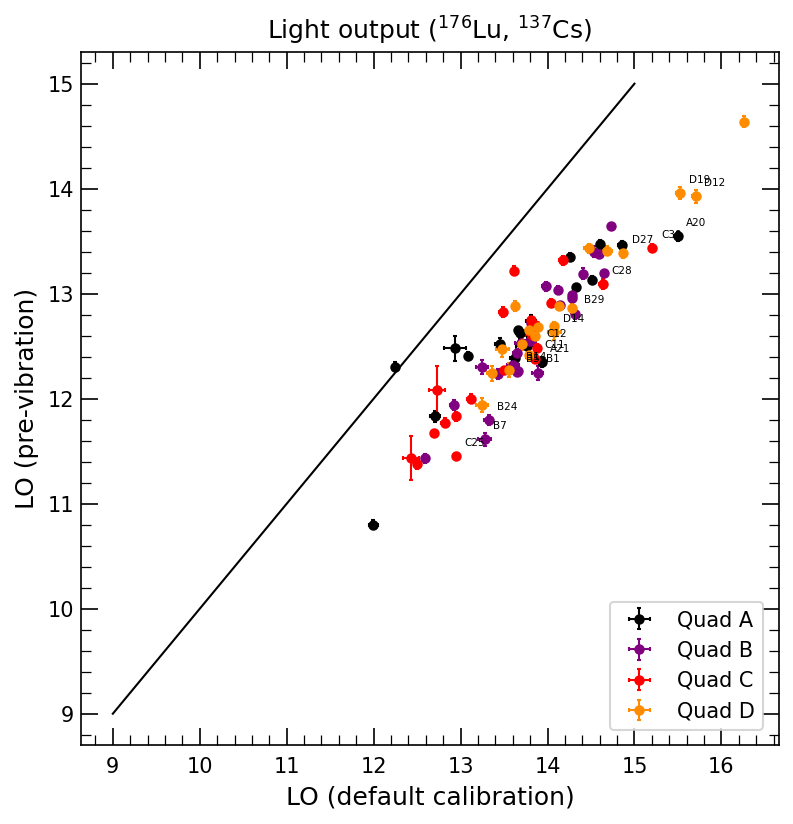

In [14]:
plt.subplots(1, 1, figsize=(6,6), dpi=150)
for quad, color in zip("ABCD",["black", "purple", "red", "darkorange"]):
    indeces = slo_calibration[quad]["light_out"].index.intersection(slo_previb_calib[quad]["light_out"].index)
    plt.errorbar(
        slo_calibration[quad]["light_out"][indeces],
        slo_previb_calib[quad]["light_out"][indeces],
        xerr=slo_calibration[quad]["light_out_err"][indeces],
        yerr=slo_previb_calib[quad]["light_out_err"][indeces],
        c=color, capsize=1.1,
        fmt = "o", label=f"Quad {quad}")
    for ch in indeces:
        x = slo_calibration[quad]["light_out"].loc[ch]
        y = slo_previb_calib[quad]["light_out"].loc[ch]
        if abs(y - x) / x > .1:
            epsilon = .1
            plt.text(x + epsilon, y + epsilon, f"{quad}{ch}", size=5)
xs = np.linspace(9, 15, 100)
plt.plot(xs, xs)
plt.ylabel("LO (pre-vibration)")
plt.xlabel("LO (default calibration)")
plt.title("Light output ($^{176}$Lu, $^{137}$Cs)")
plt.legend(loc = 4)
plt.show()

# Mini X-2

In [21]:
miniX2_fm6_path = {
    "post-tvac": "data/posttvac/merged_20241218_hermes_h6_minix2_LV0d5.fits",
}

cd109_22 = 22.1
cd109_25 = 24.9
sources = [cd109_22, cd109_25]

In [41]:
sdd_temperature_corr_calib = {}
for key, value in sdd_calibration.items():
    sdd_temperature_corr_calib[key] = sdd_calibration[key][:]
    sdd_temperature_corr_calib[key]["offset"] = sdd_temperature_corr_calib[key]["offset"] * (1 - .003)

In [42]:
calibrate_temperature_corr = partial(
    _calibrate_data,
    model=model,
    sdd_calibration=sdd_temperature_corr_calib,
    slo_calibration=slo_posttvac_calib,
    configuration=configuration,
)

In [10]:
dfs_miniX2 = {label: calibrate_standard(datafile) for label, datafile in miniX2_fm6_path.items()}

onto data/posttvac/merged_20241218_hermes_h6_minix2_LV0d5.fits..


In [43]:
dfs_corr_miniX2 = {label: calibrate_temperature_corr(datafile) for label, datafile in miniX2_fm6_path.items()}

onto data/posttvac/merged_20241218_hermes_h6_minix2_LV0d5.fits..


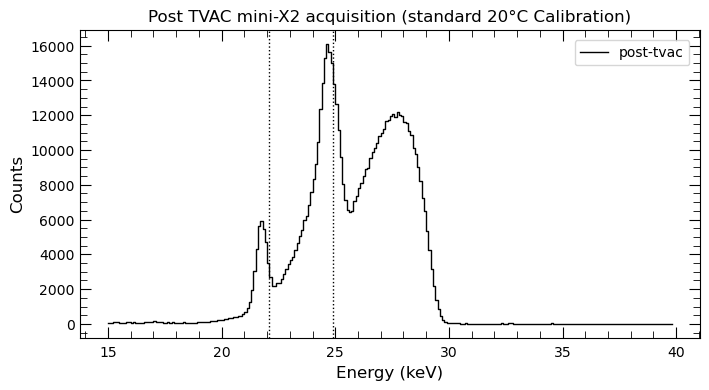

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for label, (data, calibration) in dfs_miniX2.items():
    counts, bins = np.histogram(data["ENERGY"], bins=np.arange(15, 40, 0.1))
    ax.step(bins[:-1], counts, label=label)
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
for line in sources:
    plt.axvline(line, ls="dotted")
plt.title("Post TVAC mini-X2 acquisition (standard 20°C Calibration)")
plt.show()

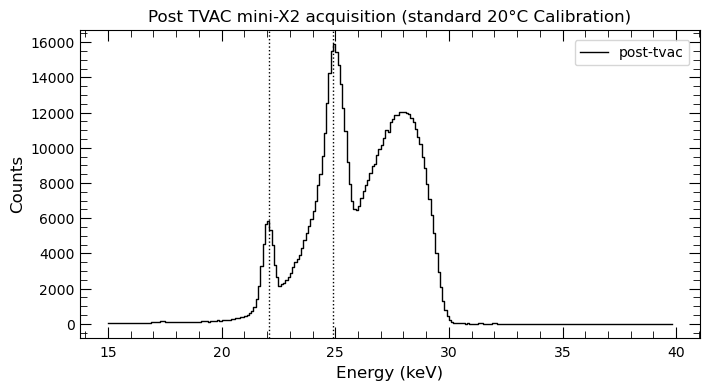

In [44]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for label, (data, calibration) in dfs_corr_miniX2.items():
    counts, bins = np.histogram(data["ENERGY"], bins=np.arange(15, 40, 0.1))
    ax.step(bins[:-1], counts, label=label)
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
for line in sources:
    plt.axvline(line, ls="dotted")
plt.title("Post TVAC mini-X2 acquisition (standard 20°C Calibration)")
plt.show()